In [ ]:
#3 [Text Classification by fine-tuning LLM model]

In [48]:
from datasets import load_dataset
data_files = {
    "train": "train.json",
    "test": "test.json",
    "validation": "validation.json"
}

ds = load_dataset("json", data_files=data_files)
ds


DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 400
    })
})

In [49]:
!pip install transformers datasets accelerate evaluate -q


In [50]:
label_cols = ['anger','anticipation','disgust','fear','joy','love',
              'optimism','pessimism','sadness','surprise','trust']


In [51]:
def encode_labels(example):
    example["labels"] = [int(example[col]) for col in label_cols]
    return example

ds = ds.map(encode_labels)


In [52]:
from transformers import AutoTokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(batch):
    return tokenizer(
        batch["Tweet"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

ds_tok = ds.map(tokenize, batched=True)


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [90]:
cols_to_remove = [
    c for c in ds_tok["train"].column_names
    if c not in ["input_ids", "token_type_ids", "attention_mask", "labels"]
]

ds_tok = ds_tok.remove_columns(cols_to_remove)


In [92]:
import torch
def hf_to_torch(ds_split):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    labels = []
    for row in ds_split:
        input_ids.append(row["input_ids"].tolist())
        attention_masks.append(row["attention_mask"].tolist())
        token_type_ids.append(row["token_type_ids"].tolist())
        labels.append([float(x) for x in row["labels"]])
    return {
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "attention_mask": torch.tensor(attention_masks, dtype=torch.long),
        "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        "labels": torch.tensor(labels, dtype=torch.float32),
    }
train_pt = hf_to_torch(ds_tok["train"])
val_pt   = hf_to_torch(ds_tok["validation"])
test_pt  = hf_to_torch(ds_tok["test"])


In [93]:
class PTDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data["labels"])
    def __getitem__(self, idx):
        return {
            "input_ids": self.data["input_ids"][idx],
            "attention_mask": self.data["attention_mask"][idx],
            "token_type_ids": self.data["token_type_ids"][idx],
            "labels": self.data["labels"][idx],
        }
train_dataset = PTDataset(train_pt)
val_dataset   = PTDataset(val_pt)
test_dataset  = PTDataset(test_pt)


In [94]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=11,
    problem_type="multi_label_classification"
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
import evaluate
f1 = evaluate.load("f1")
import torch
def sigmoid(x):
    return 1/(1+torch.exp(-x))
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = sigmoid(torch.tensor(logits))
    preds = (probs > 0.5).int()
    return {
        "f1_macro": f1.compute(
            predictions=preds,
            references=labels,
            average="macro"
        )["f1"]
    }



In [99]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="./bert-multi-label",
    do_train=True,
    do_eval=True,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=500,
    save_total_limit=1
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [100]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-890265614.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [101]:
trainer.train()


Step,Training Loss
50,0.452800
100,0.417100
150,0.414500
200,0.391200
250,0.366800
300,0.377400
350,0.365900
400,0.330600
450,0.324700
500,0.322100


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1875, training_loss=0.28661334737141925, metrics={'train_runtime': 13528.7336, 'train_samples_per_second': 1.109, 'train_steps_per_second': 0.139, 'total_flos': 986746187520000.0, 'train_loss': 0.28661334737141925, 'epoch': 5.0})

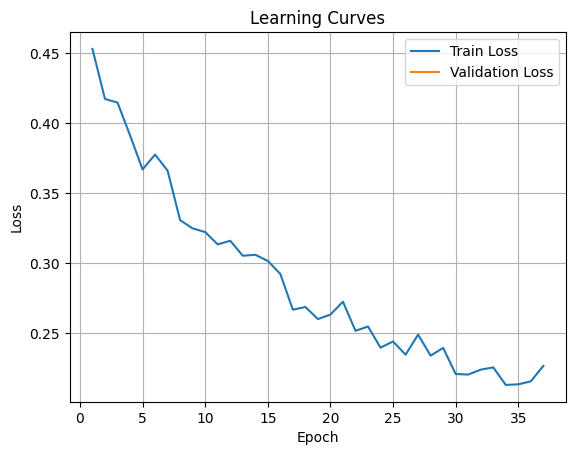

In [102]:
import matplotlib.pyplot as plt
log = trainer.state.log_history
train_loss = [x["loss"] for x in log if "loss" in x]
eval_loss = [x["eval_loss"] for x in log if "eval_loss" in x]
epochs_train = list(range(1, len(train_loss) + 1))
epochs_eval = list(range(1, len(eval_loss) + 1))
plt.plot(epochs_train, train_loss, label="Train Loss")
plt.plot(epochs_eval, eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves")
plt.legend()
plt.grid()
plt.show()


In [109]:
class FloatLabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        inputs["labels"] = inputs["labels"].to(torch.float32)
        return super().compute_loss(model, inputs, return_outputs=return_outputs, **kwargs)

    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None, **kwargs):
        inputs["labels"] = inputs["labels"].to(torch.float32)
        return super().prediction_step(
            model,
            inputs,
            prediction_loss_only=prediction_loss_only,
            ignore_keys=ignore_keys,
            **kwargs
        )


In [110]:
trainer = FloatLabelTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"]
)


In [111]:
pred_output = trainer.predict(ds_tok["test"])
logits = pred_output.predictions
labels_true = pred_output.label_ids



In [112]:
import torch
probs = torch.sigmoid(torch.tensor(logits))
pred_labels = (probs > 0.5).int().numpy()


In [113]:
import numpy as np
strict_correct = np.all(pred_labels == labels_true, axis=1)
strict_accuracy = strict_correct.mean()
print("Strict Test Accuracy (all labels must match):", strict_accuracy)


Strict Test Accuracy (all labels must match): 0.2673333333333333


In [114]:
relaxed_correct = np.any((pred_labels == 1) & (labels_true == 1), axis=1)
relaxed_accuracy = relaxed_correct.mean()
print("Relaxed Test Accuracy (≥1 label matches):", relaxed_accuracy)


Relaxed Test Accuracy (≥1 label matches): 0.8506666666666667
